In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

In [3]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
import torch

# Context length of how many characters support the prediction. This is consistent with
# the paper we're following
block_size = 3

x, y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        x.append(context)
        y.append(ix)
        #print(''.join(itos[i] for i in context), "--->", ch)
        # Advance the rolling window of context
        context = context[1:] + [ix]


X = torch.tensor(x)
Y = torch.tensor(y)

In [99]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [98]:
# Build dataset splits
def build_dataset(words: list[str], block_size: int) -> (torch.tensor, torch.tensor):
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), "--->", ch)
            # Advance the rolling window of context
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

CONTEXT_SZ = 5
Xtr, Ytr = build_dataset(words[:n1], CONTEXT_SZ)
Xdev, Ydev = build_dataset(words[n1:n2], CONTEXT_SZ)
Xte, Yte = build_dataset(words[n2:], CONTEXT_SZ)


torch.Size([182512, 5]) torch.Size([182512])
torch.Size([22860, 5]) torch.Size([22860])
torch.Size([22774, 5]) torch.Size([22774])


# Embedding Lookup table

In [8]:
import torch.nn.functional as F

# C is the lookup table which is the first layer of the network
C = torch.randn((27, 2))
C.shape

torch.Size([27, 2])

In [400]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

# Hidden Layer

In [401]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [402]:
# Hidden layer of activations for examples

# torch.concat(emb[:, 0, :], emb[:, 1, :], emb[:, 2, :])
# torch.unbind(emb, 1), 1)
h = torch.tanh(emb.view(-1, 6) @ W1 + b)
h.shape

torch.Size([228146, 100])

# Output layer

In [403]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + B2
logits.shape

torch.Size([228146, 27])

In [342]:
counts = logits.exp()
counts.shape

torch.Size([228146, 27])

In [343]:
probs = counts / counts.sum(1, keepdim=True)
probs.shape

torch.Size([228146, 27])

# Negative Log Likelihood Loss

In [ ]:
# Current probabilities to the correct character in the sequence
loss = -probs[torch.arange(32), Y].log().mean()
loss.item()

In [197]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [96]:
# Model from last time

N = torch.zeros(len(stoi), len(stoi), dtype=torch.int32)
for w in words:
    chs = ['.']  + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1
P = (N+1).float()
P /= P.sum(1, keepdim=True)


tensor([[3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
         1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
         4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
         5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
         4.2109e-03, 1.6719e-02, 2.9008e-02],
        [1.9583e-01, 1.6425e-02, 1.5983e-02, 1.3889e-02, 3.0756e-02, 2.0435e-02,
         3.9809e-03, 4.9835e-03, 6.8796e-02, 4.8685e-02, 5.1899e-03, 1.6779e-02,
         7.4575e-02, 4.8213e-02, 1.6039e-01, 1.8872e-03, 2.4475e-03, 1.7988e-03,
         9.6279e-02, 3.2997e-02, 2.0288e-02, 1.1264e-02, 2.4623e-02, 4.7771e-03,
         5.3963e-03, 6.0480e-02, 1.2857e-02],
        [4.3039e-02, 1.2051e-01, 1.4596e-02, 7.4850e-04, 2.4701e-02, 2.4551e-01,
         3.7425e-04, 3.7425e-04, 1.5719e-02, 8.1587e-02, 7.4850e-04, 3.7425e-04,
         3.8922e-02, 3.7425e-04, 1.8713e-03, 3.9671e-02, 3.7425e-04, 3.7425e-04,
         3.1549e-

# Cleaned Up

In [195]:
EMBED_SZ = 32
HIDDEN_LAYER_SZ = 96
OUTPUT_SZ = 27
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, EMBED_SZ), generator=g)

W1 = torch.randn((CONTEXT_SZ * EMBED_SZ, HIDDEN_LAYER_SZ), generator=g)
b1 = torch.randn(HIDDEN_LAYER_SZ, generator=g)

W2 = torch.randn((HIDDEN_LAYER_SZ, OUTPUT_SZ), generator=g)
b2 = torch.randn(OUTPUT_SZ, generator=g)

parameters = [C, W1, b1, W2, b2]

In [196]:
# Total number of parameters
sum(p.nelement() for p in parameters)

18939

In [197]:
# Reset parameters for training
for p in parameters:
    p.requires_grad = True

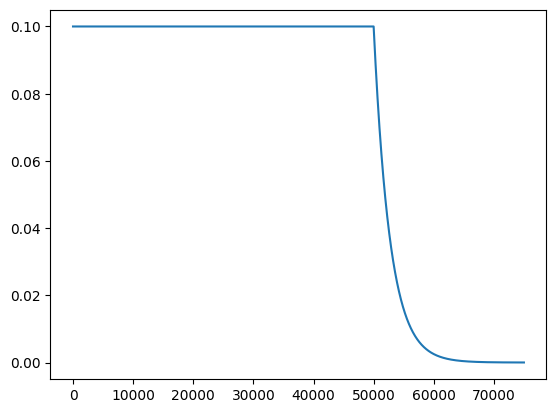

In [198]:
# It doesn't make sense to step through the learning rate linearly. Instead, we'll
# step through the exponents linearly.
lre = torch.cat([-1 * torch.ones(100000), torch.linspace(-1, -5, steps=50000)])
lrs = 10**lre

#lrs = [0.1] * 90000 + [0.01] * 50000
plt.plot(range(0, len(lrs)), lrs)

In [199]:
from torch import nn

relu = nn.ReLU()

def tanh_activation(x):
    return torch.tanh(x)

def relu_activation(x):
    return relu(x)

activation = relu_activation

In [200]:
from statistics import mean
from tqdm import tqdm

MINI_BATCH_SZ = 128

lri = []
lossi = []
loglossi = []
loglossiavg = []
stepi = []


pbar = tqdm(range(len(lrs)))
for i in pbar:
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (MINI_BATCH_SZ,)) # (MINI_BATCH_SZ)

    # Forward Pass
    emb = C[Xtr[ix]] # (MINI_BATCH_SZ, CONTEXT_SZ, 2)
    h = activation(emb.view(-1, CONTEXT_SZ * EMBED_SZ) @ W1 + b1) # (MINI_BATCH_SZ, HIDDEN_LAYER_SZ)
    logits = h @ W2 + b2 # (HIDDEN_LAYER_SZ, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # Backward pass
    #for p in parameters:
    #    p.grad = None
    

    # Update parameters
    lr = lrs[i]

    sgd = torch.optim.SGD(parameters, lr=lr, weight_decay=0.001)
    sgd.zero_grad()
    loss.backward()
    sgd.step()

    #for p in parameters:
    #    p.data += -lr * p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
    if i < 500:
        loglossiavg.append(loss.log10().item())
    else:
        loglossiavg.append(mean(loglossi[-500:]))
    if i % 1000 == 0:
        pbar.set_description("LR: %0.4f Loss %0.4f" % (lr, mean(lossi[-500:])))
    #lri.append(lre[i])
print(loss.item())


LR: 0.0000 Loss 2.0950: 100%|██████████| 75000/75000 [00:46<00:00, 1609.96it/s]

1.9020644426345825


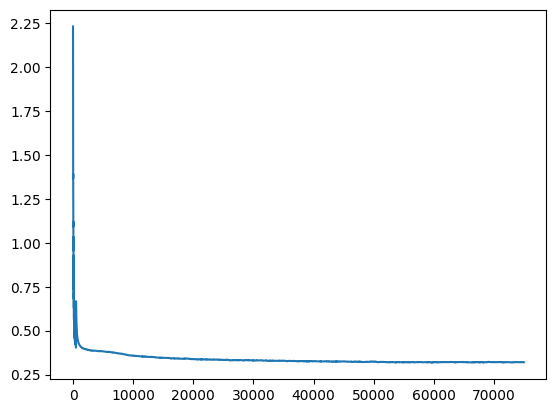

In [201]:
plt.plot(stepi, loglossiavg)

In [202]:
# Loss on training set
def loss(x, y) -> float:
    emb = C[x] # (32, 3, 2)
    h = activation(emb.view(-1, CONTEXT_SZ * EMBED_SZ) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    return F.cross_entropy(logits, y).item()

print({
    'MINI_BATCH_SZ': MINI_BATCH_SZ,
    'CONTEXT_SZ': CONTEXT_SZ,
    'EMBED_SZ': EMBED_SZ,
    'HIDDEN_LAYER_SZ': HIDDEN_LAYER_SZ,
    'num_parameters': sum(p.nelement() for p in parameters),
})

xtr_loss = loss(Xtr, Ytr)
print(f"Xtr loss: {xtr_loss:0.4f}")

xdev_loss = loss(Xdev, Ydev)
print(f"Xdev loss: {xdev_loss:0.4f}")

{'MINI_BATCH_SZ': 256, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0915
Xdev loss: 2.1072


In [ ]:
# Loss on entire training set
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, CONTEXT_SZ * EMBED_SZ) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print(loss.item())

In [ ]:
# Display embeddings. This works w/ lower dimension embeddings.
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# Challenge

Knobs available:
- number of neurons in hidden layer
- embedding table size
- numbers of characters as input
- details of optimization
- batch size (convergence speed)

Read the paper, and it also has ideas for improvements.

# Sample from the model

In [146]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * CONTEXT_SZ
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = activation(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        # Make logits sum to 1
        probs = F.softmax(logits, dim=1)

        # Sample from probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


carmah.
amille.
khismir.
rehty.
salaya.
ejrahnen.
deliah.
jareei.
nermara.
chaiir.
kaleig.
dham.
joce.
quinn.
shoil.
alian.
quwanthon.
jaryni.
jaceelinsa.
medde.


# Challenge Progress

Prior loss on dev set: 2.17

## Update the batch size

First attempt to update `CONTEXT_SZ` from 3 to 4.
EMBED_SZ = 10

Attempting two rounds of optimization:
- 100k at 0.1
- 100k at 0.01
- 200k at 0.01:  Xtr: 2.11, Xdev: 2.16
- 200k at 0.001: Xtr: 2.10, Xdev: 2.14

Since the training and dev set are diverging this tells me that continuing to train may just be over fitting.

## Rewriting the learning rates

Training Optimization: `lrs = [0.1] * 100000 + [0.01] * 200000 + [0.001] * 100000`

Results:
- Xtr: 2.13, Xdev: 2.16

## Mini batch size as 64

Training Optimization: `lrs = [0.1] * 100000 + [0.01] * 200000 + [0.001] * 100000`
MINI_BATCH_SZ = 64 (double 32)
Revert CONTEXT_SZ to 3

Results:

- Xtr: 2.10, Xdev: 2.14


## Mini batch size as 128

Training Optimization: `lrs = [0.1] * 100000 + [0.01] * 200000`
MINI_BATCH_SZ = 128 
CONTEXT_SZ to 3

Results:
- Xtr: 2.10, Xdev: 2.14

## Mini batch at 32 again

Training Optimization: `lrs = [0.1] * 100000 + [0.01] * 200000 + [0.001] * 100000`
MINI_BATCH_SZ = 32
CONTEXT_SZ to 3

Results:
- Xtr: 2.12, Xdev: 2.16

## Training Optimization Only: Linear walk through exponents

```
lre = torch.linspace(-1, -4, steps=300000)
lrs = 10**lre
```
MINI_BATCH_SZ = 32
CONTEXT_SZ to 3

Results:
- Xtr: 2.17, Xdev: 2.19

## Training optimization only: More time at 0.1

```
lre = torch.cat([-1 * torch.ones(100000), torch.linspace(-1, -3, steps=400000)])
```
MINI_BATCH_SZ = 32
CONTEXT_SZ to 3

Results:
- Xtr: 2.06, Xdev: 2.12

This is very likely overfitting?

## Backing off to moderate training optimization

```
lre = torch.cat([-1 * torch.ones(75000), torch.linspace(-1.5, -4, steps=200000)])
```
- Xtr: 2.12, Xdev: 2.159

## Context size increase to 5

15k parameters
CONTEXT_SZ = 5
- Xtr: 2.18, Xdev: 2.20

## Embedding size increase to 20

Preserved learning rate
CONTEXT_SZ = 5
EMBED_SZ = 20
26k parameters
- Xtr: 2.21, Xdev: 2.25

# Embedding size to 20 w/ content size reverted

Preserved learning rate
CONTEXT_SZ = 3
EMBED_SZ = 20
26k parameters
- Xtr: 2.07, Xdev: 2.13

# Go big

Learning: ```lre = torch.cat([-1 * torch.ones(10000), torch.linspace(-1.5, -4, steps=300000)])```
MINI_BATCH_SZ = 512
CONTEXT_SZ = 6
EMBED_SZ = 100
HIDDEN_LAYER_SZ = 500

Result:
- Xtr: 2.08, Xdev: 2.68

Massive overfitting!



## Learning rate revert

```lre = torch.cat([-1 * torch.ones(100000), torch.linspace(-1, -5, steps=300000)])```

## Reading the research paper

From the paper:
> the vocabulary size is |V| = 17,964, the number of hidden units is h = 60, the order
of the model is n = 6, the number of word features is m = 100.

From the paper results, seems like:
- n=3, h=100, m=30 did well

Perhaps adding another layer would help? This turned out to not work at all with the above learning rate.

## Back down to earth

CONTEXT_SZ = 3
EMBED_SZ = 6
HIDDEN_LAYER_SZ = 16
BATCH_SIZE = 32

Result:
- Xtr: 2.28, Xdev: 2.29

## Bring back up parameters


Learning: `lre = torch.cat([-1 * torch.ones(100000), -2 * torch.ones(100000), torch.linspace(-2, -5, steps=100000)])`
EMBED_SZ = 16
HIDDEN_LAYER_SZ = 27
OUTPUT_SZ = 27
MINI_BATCH_SZ = 64

Result:
- Xtr: 2.23, Xdev: 2.24

## What was the key from before?

Seems like hidden layer size was the main difference..

`lre = torch.cat([-1 * torch.ones(100000), -2 * torch.ones(100000), torch.linspace(-2, -5, steps=100000)])`
EMBED_SZ = 16
HIDDEN_LAYER_SZ = 128
OUTPUT_SZ = 27
MINI_BATCH_SZ = 64

Result:
- Xtr: 2.09, Xdev: 2.16

## Caps

`lre = torch.cat([-1 * torch.ones(75000), -2 * torch.ones(75000), torch.linspace(-2, -5, steps=250000)])`
EMBED_SZ = 32
HIDDEN_LAYER_SZ = 256
OUTPUT_SZ = 27
MINI_BATCH_SZ = 64

Result:
- Xtr: 2.02, Xdev: 2.16

## Bring back context size again, Lowering Embed and hidden layers to avoid overfitting

`lre = torch.cat([-1 * torch.ones(75000), -2 * torch.ones(75000), torch.linspace(-2, -5, steps=250000)])`
CONTEXT_SZ = 4
EMBED_SZ = 16
HIDDEN_LAYER_SZ = 128
OUTPUT_SZ = 27
12k parameters

Result:
- Xtr: 2.10, Xdev: 2.15

## All about the learning rates

```
lre = torch.cat([-1 * torch.ones(200000), -2 * torch.ones(75000), torch.linspace(-2, -5, steps=50000)])
{'MINI_BATCH_SZ': 64, 'CONTEXT_SZ': 4, 'EMBED_SZ': 16, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 2.0524
Xdev loss: 2.1219
```

# Further learning adjustments

Attempted to avoid over fitting by staying longer on larger learning rate.

```
lre = torch.cat([-1 * torch.ones(250000), torch.linspace(-1, -5, steps=100000)])
{'MINI_BATCH_SZ': 64, 'CONTEXT_SZ': 4, 'EMBED_SZ': 16, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 2.0324
Xdev loss: 2.1093
```

Next, will try adjusting the batch size further. Maybe also do fewer steps on the later space.

# Weight Decay experiment

Using a weight decay did seem to reduce the amount of overfitting, though lost some of the
gains seen in the losses.

```
weight_decay=0.001

{'MINI_BATCH_SZ': 64, 'CONTEXT_SZ': 4, 'EMBED_SZ': 16, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 2.1361
Xdev loss: 2.1465
```

# Embedding Size

```
{'MINI_BATCH_SZ': 64, 'CONTEXT_SZ': 4, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 2.1279
Xdev loss: 2.1391
```

# Bigger Embed and hidden layers

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 4, 'EMBED_SZ': 64, 'HIDDEN_LAYER_SZ': 256}
Xtr loss: 2.1183
Xdev loss: 2.1309
```

This didn't add anything.

Reducing embed size, hidden layers, and # of steps w/ learning rate didn't lose anything:

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 4, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 2.1218
Xdev loss: 2.1324
```

# Increase Context Size

Now increasing context size seemed to help:

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 2.0940
Xdev loss: 2.1102
```

However, increasing it more just overfit:

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 6, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 128, 'num_parameters': 29051}
Xtr loss: 2.0858
Xdev loss: 2.1149
```

Reverting back content size, and lowering embed / hidden layer size didn't seem to hurt.

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 24, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 14883}
Xtr loss: 2.0974
Xdev loss: 2.1122
```

# Activation function

Picking the RELU activation function seemed to perform much better.

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 24, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 14883}
Xtr loss: 2.0615
Xdev loss: 2.0809
```

# Increased batch sizes

```
{'MINI_BATCH_SZ': 256, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0776
Xdev loss: 2.0962
```